# GP-KANの学習安定化方法調査: b.正規化項調整

## 0.背景/目的
GP-KANの学習(誘導点・カーネルパラメータの同時学習)時、処理がうまくいかない現象が発生していた。

原因として考えられるのは以下の通り：

* a. カーネル行列のJitter項が大きい※1ため、出力層以外の誘導点が縦に並んでいる(x軸:入力,y軸:中間層出力)
* b. バッチサイズが小さいことで、ミニバッチデータに偏りが生じる
* c. 損失関数(負の対数尤度)は誘導点が近いほど小さい値を取るため、カーネル行列が縮退しやすい

※1. 関数値を取る確率変数 $f\sim GP(m(\cdot),k(\cdot, \cdot))$ と独立なノイズが多く含まれることに相当する。
ここで、GPの出力 $y$ に対して
$$
y = f(x)+\epsilon,\ \ \  \epsilon\sim \mathcal{N}(0, \sigma_\epsilon^2)
$$

そのため、以下の追加実験を行いGP-KANの学習が安定しない原因のあたりをつける。

* a. Jitter項のパラメータ設定値を小さくして学習実行
* b. バッチサイズ(現在32; 学習データ全体750件)を小さくする
* c. 誘導点が近づかないようなペナルティ項入れて学習

本notebookでは、<span style="color: red;">b.の検証として</span>以下設定で学習を行い結果を評価する：
### モデル構成
- **ネットワーク構造**: 2層GP-KAN (入力1次元 → 中間層1次元 → 出力1次元)
- **誘導点数**: 各GPあたり10点
- **GP構成**: (0,0), (1,0) の2つのガウス過程

### 学習パラメータ
- **エポック数**: 400エポック
- **学習率**: 1e-5
- **バッチサイズ**: 32
- **事前学習**: 無効 (pretrain=False)

### 正則化パラメータ
- **global_jitter**: <span style="color: red;">**1e-4**</span>
- **baseline_jitter**: 1e-3

In [ ]:
GLOBAL_JITTER_VALUE = 1e-4
BASELINE_JITTER_VALUE = 1e-3

In [ ]:
SAVELOAD_PATH = "model_12_b1.pt"

## 1.問題設定

真の関数: フーリエ級数
$$f(t) = \frac{4}{\pi} \sum_{n=1}^{N} \frac{1}{n} \sin(nt), \quad n = 1, 3, 5, \ldots, \quad t \in [0, 1]$$
※$N=15$

データ: 
- 合計1,000件: 学習700件/検証150件/評価150件
- tは$(-1,1)$から一様ランダムサンプリング

モデル:
- 2層のGPKAN: 入力1次元/中間層1次元/出力1次元
    - それぞれのGPを(<1層目のindex>,<2層目のindex>)形式で表すことにすると、GPKANは$(0,0),(1,0)$の2つのGPで構成



## 2.メイン処理
本ノートブックのメイン処理を実行する。実行順は以下の通り：

2-1.データセット作成

2-2.GPKANの学習

2-3.精度評価

2-4.学習中のカーネル行列ランク可視化

### 2-1.データセット作成

In [ ]:
# 初期設定: 必要なライブラリをインポートし、パスを設定
import os
import sys

sys.path.append("../")
import japanize_matplotlib
import torch.utils.data
from lib import model as gplib
from lib import runner
from torch.utils.data import DataLoader

In [ ]:
import random

import matplotlib.pyplot as plt
import numpy as np
import torch
from torch.utils.data import DataLoader, TensorDataset


# Generate synthetic data with Fourier series function
def set_seed(seed=42):
    """完全な再現性のための乱数シード設定"""
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)


def worker_init_fn(worker_id):
    """DataLoaderワーカープロセス用の乱数シード設定"""
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)


set_seed(42)  # 全体の乱数シード設定
num_samples = 1000

# Generate random input points t from [-1, 1]
t = np.random.uniform(-1, 1, num_samples)


# Compute target values: f(t) = (4/π) * Σ(1/n * sin(nt)) for odd n up to N=15
def fourier_series(t, N=15):
    result = np.zeros_like(t)
    for n in range(1, N + 1, 2):  # odd numbers only: 1, 3, 5, 7, 9, 11, 13, 15
        result += (1 / n) * np.sin(n * t)
    return (4 / np.pi) * result


targets = fourier_series(t, N=15)

# Reshape inputs (t is 1D, but we need it as 2D for compatibility)
inputs = t.reshape(-1, 1)

# Convert to PyTorch tensors
X_tensor = torch.FloatTensor(inputs)
y_tensor = torch.FloatTensor(targets).reshape(-1, 1)

# Split data into train, validation, and test sets
train_size = int(0.7 * num_samples)
val_size = int(0.15 * num_samples)
test_size = num_samples - train_size - val_size

X_train = X_tensor[:train_size]
y_train = y_tensor[:train_size]

X_val = X_tensor[train_size : train_size + val_size]
y_val = y_tensor[train_size : train_size + val_size]

X_test = X_tensor[train_size + val_size :]
y_test = y_tensor[train_size + val_size :]

# データを昇順にソート（X_testとy_testを対応を保ちながら）
sorted_indices = torch.argsort(X_test.squeeze())
X_test = X_test[sorted_indices]
y_test = y_test[sorted_indices]

# Create datasets
train_dataset = TensorDataset(X_train, y_train)
val_dataset = TensorDataset(X_val, y_val)
test_dataset = TensorDataset(X_test, y_test)

# Create dataloaders
batch_size = 32

In [ ]:
# Create dataloaders with reproducible worker processes
generator = torch.Generator()
generator.manual_seed(42)

train_dataloader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=0,  # Single process for reproducibility
    worker_init_fn=worker_init_fn,
    generator=generator,
)
val_dataloader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=0,  # Single process for reproducibility
    worker_init_fn=worker_init_fn,
    generator=generator,
)
test_dataloader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=0,  # Single process for reproducibility
    worker_init_fn=worker_init_fn,
    generator=generator,
)

Train samples: 700
Validation samples: 150
Test samples: 150


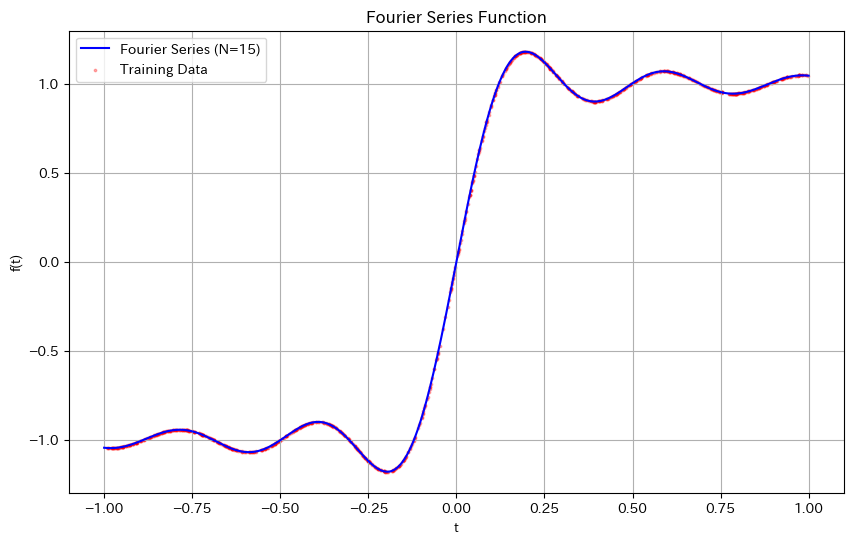

In [ ]:
# サンプル数確認
print(f"Train samples: {len(train_dataset)}")
print(f"Validation samples: {len(val_dataset)}")
print(f"Test samples: {len(test_dataset)}")

# Fourier級数関数のプロット
t_plot = np.linspace(-1, 1, 1000)
y_plot = fourier_series(t_plot, N=15)
plt.figure(figsize=(10, 6))
plt.plot(t_plot, y_plot, "b-", label="Fourier Series (N=15)")
plt.scatter(t, targets, alpha=0.3, s=3, c="red", label="Training Data")
plt.xlabel("t")
plt.ylabel("f(t)")
plt.title("Fourier Series Function")
plt.legend()
plt.grid(True)
plt.show()

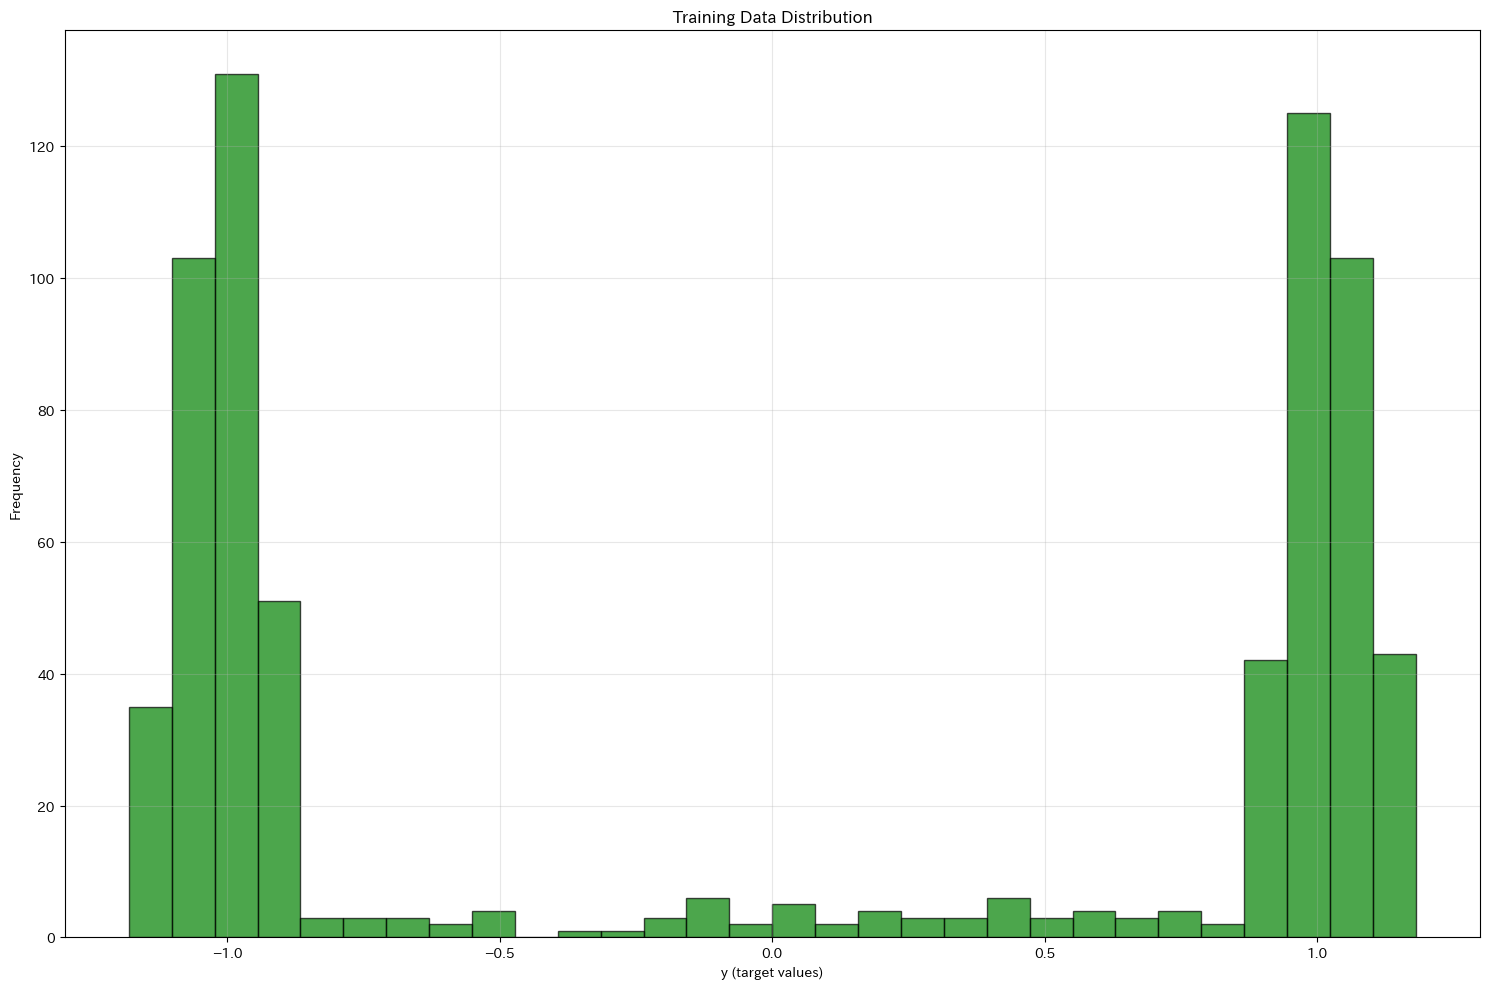


=== 値の分布特性 ===
正の値の割合: 49.7%
負の値の割合: 50.3%
ゼロ近傍(-0.1 < y < 0.1)の割合: 1.3%


In [ ]:
# y（目的変数）の分布をヒストグラムで可視化
plt.figure(figsize=(15, 10))


# 学習データのヒストグラム
plt.subplot(1, 1, 1)
plt.hist(
    y_train.numpy().flatten(), bins=30, alpha=0.7, color="green", edgecolor="black"
)
plt.xlabel("y (target values)")
plt.ylabel("Frequency")
plt.title("Training Data Distribution")
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


# 値の分布特性
print(f"\n=== 値の分布特性 ===")
print(f"正の値の割合: {np.sum(targets > 0) / len(targets) * 100:.1f}%")
print(f"負の値の割合: {np.sum(targets < 0) / len(targets) * 100:.1f}%")
print(
    f"ゼロ近傍(-0.1 < y < 0.1)の割合: {np.sum(np.abs(targets) < 0.1) / len(targets) * 100:.1f}%"
)

### 2-2.モデル学習

In [ ]:
num_gp_pts = 10  # Number of Gaussian Process points
model = gplib.GP_Model(
    [
        gplib.LayerFused(1, 1, num_gp_pts),
        gplib.LayerFused(1, 1, num_gp_pts),
    ],
    saveload_path=SAVELOAD_PATH,  # Path to save/load the model
)
np.random.seed(42)  # for reproducibility
torch.manual_seed(42)

In [ ]:
# 精度評価/可視化関数
def plot_result(model):
    # テストデータでの予測
    with torch.no_grad():
        # バッチごとに予測を行う
        test_predictions = []
        test_targets = []
        test_variances = []

        for X_batch, y_batch in test_dataloader:
            pred = model.predict(X_batch).mean
            var = model.predict(X_batch).var
            test_predictions.append(pred)
            test_variances.append(var)
            test_targets.append(y_batch)

        # 結果を結合
        test_predictions = torch.cat(test_predictions, dim=0)
        test_targets = torch.cat(test_targets, dim=0)
        test_variances = torch.cat(test_variances, dim=0)

    # MSE計算
    mse = torch.mean((test_predictions - test_targets) ** 2)
    rmse = torch.sqrt(mse)

    print(f"Test MSE: {mse.item():.6f}")
    print(f"Test RMSE: {rmse.item():.6f}")

    # 可視化用のデータ準備
    t_test = X_test.numpy().flatten()
    y_test_true = y_test.numpy().flatten()
    y_test_pred = test_predictions.numpy().flatten()

    # 真の関数の連続プロット用
    t_continuous = np.linspace(-1, 1, 500)
    y_continuous = fourier_series(t_continuous, N=15)

    # グラフ作成
    plt.figure(figsize=(12, 8))

    # 真の関数
    plt.plot(
        t_continuous,
        y_continuous,
        "b-",
        linewidth=2,
        label="True Function (Fourier Series)",
        alpha=0.8,
    )

    # テストデータの真値
    plt.scatter(
        t_test,
        y_test_true,
        c="red",
        s=30,
        alpha=0.6,
        label="Test Data (True)",
        marker="o",
    )

    # 予測値
    plt.scatter(
        t_test, y_test_pred, c="green", s=30, alpha=0.6, label="Predictions", marker="x"
    )

    # 予測の不確実性を帯で表示
    lower_bound = y_test_pred - 1.96 * np.sqrt(test_variances.numpy().flatten())
    upper_bound = y_test_pred + 1.96 * np.sqrt(test_variances.numpy().flatten())
    plt.fill_between(
        t_test,
        lower_bound,
        upper_bound,
        color="lightgreen",
        alpha=0.3,
        label="95% Prediction Interval",
    )

    plt.xlabel("t")
    plt.ylabel("f(t)")
    plt.title(f"GP-KAN Prediction vs True Function\nTest RMSE: {rmse.item():.6f}")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

    # 残差プロット
    plt.figure(figsize=(10, 6))
    residuals = y_test_pred - y_test_true
    plt.scatter(t_test, residuals, c="purple", s=30, alpha=0.6)
    plt.axhline(y=0, color="red", linestyle="--", alpha=0.7)
    plt.xlabel("t")
    plt.ylabel("Residuals (Predicted - True)")
    plt.title("Residual Plot")
    plt.grid(True, alpha=0.3)
    plt.show()

    # 残差の統計情報
    print(f"\nResidual Statistics:")
    print(f"Mean: {np.mean(residuals):.6f}")
    print(f"Std: {np.std(residuals):.6f}")
    print(f"Min: {np.min(residuals):.6f}")
    print(f"Max: {np.max(residuals):.6f}")

    print("plot completed")
    return 0

epoch 0  , train negloglik: 1225.18545,    val negloglik: 1.56334    accuracy: 0.5154 lr: [1e-05]
epoch 1  , train negloglik: 1.53383,    val negloglik: 1.51508    accuracy: 0.9044 lr: [9e-06]
epoch 2  , train negloglik: 1.50394,    val negloglik: 1.48849    accuracy: 0.9377 lr: [9e-06]
epoch 3  , train negloglik: 1.48276,    val negloglik: 1.46995    accuracy: 0.9479 lr: [9e-06]
epoch 4  , train negloglik: 1.46373,    val negloglik: 1.44789    accuracy: 0.9264 lr: [9e-06]
epoch 5  , train negloglik: 1.44346,    val negloglik: 1.43225    accuracy: 0.9452 lr: [9e-06]
epoch 6  , train negloglik: 1.42714,    val negloglik: 1.40812    accuracy: 0.9050 lr: [9e-06]
epoch 7  , train negloglik: 1.40559,    val negloglik: 1.39445    accuracy: 0.9093 lr: [9e-06]
epoch 8  , train negloglik: 1.39223,    val negloglik: 1.37969    accuracy: 0.9173 lr: [9e-06]
epoch 9  , train negloglik: 1.37918,    val negloglik: 1.36861    accuracy: 0.9292 lr: [9e-06]
epoch 10 , train negloglik: 1.36886,    val neg

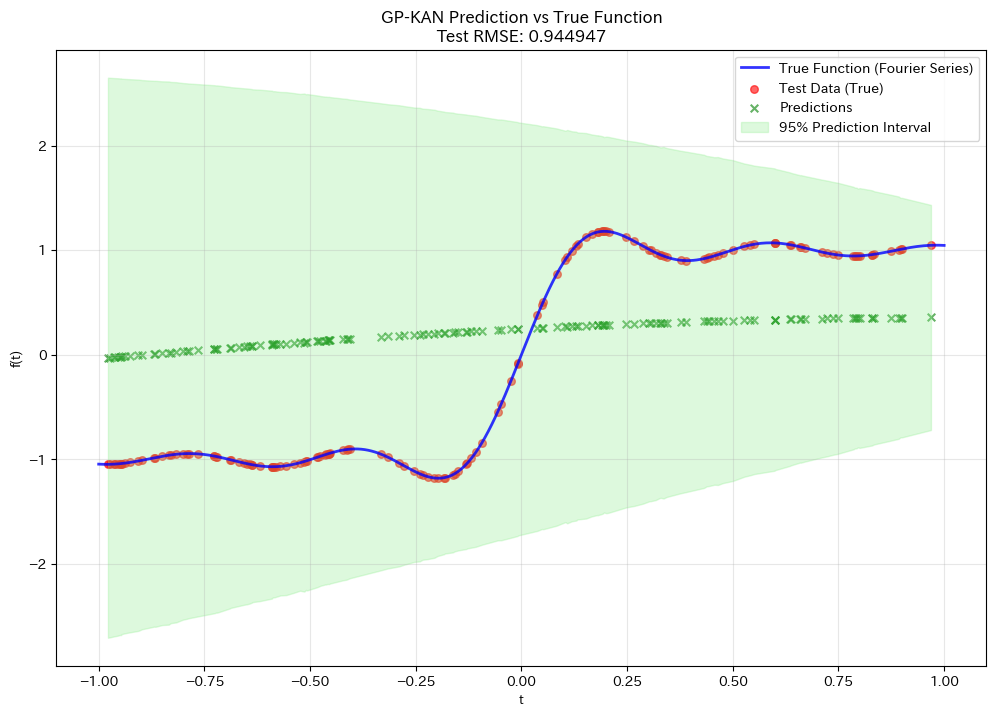

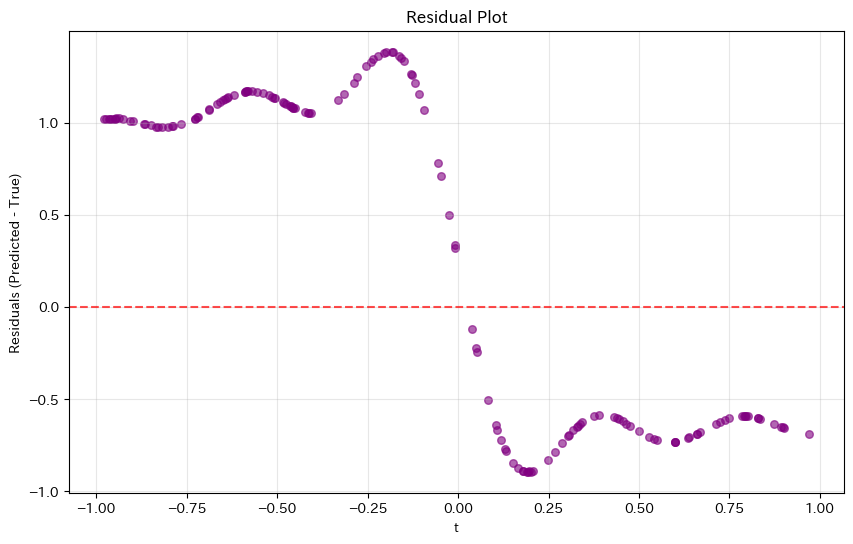


Residual Statistics:
Mean: 0.325722
Std: 0.887034
Min: -0.895099
Max: 1.385029
plot completed


In [ ]:
for epoch in range(1):
    runner.train_model(
        train_dataloader,
        val_dataloader,
        model,
        epochs=400,
        learning_rate=1e-5,
        use_gpu=False,  # True,
        pretrain=False,  # True,
        global_jitter=GLOBAL_JITTER_VALUE,
        baseline_jitter=BASELINE_JITTER_VALUE,
    )
    model.save_model()  # optionally save the model after training

    # 可視化
    plot_result(model)

## 2-3.結果評価
以下の項目に従ってカーネル行列の分析結果をまとめる：

**カーネル行列分析項目**
- 各層のカーネル行列ランクと条件数の分析
- 誘導点の分布と配置の可視化
- カーネル行列のヒートマップ（Jitter項適用前後）
- 固有値分布の分析
- 誘導点間距離の統計的分析

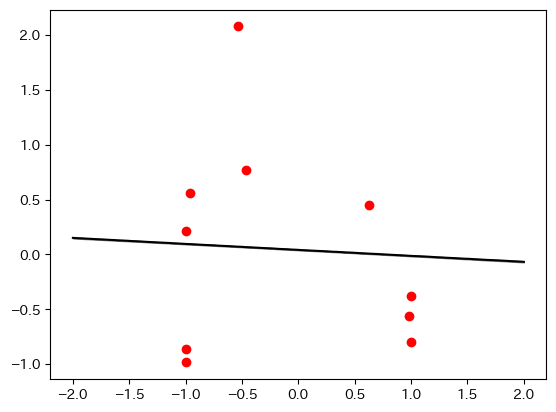

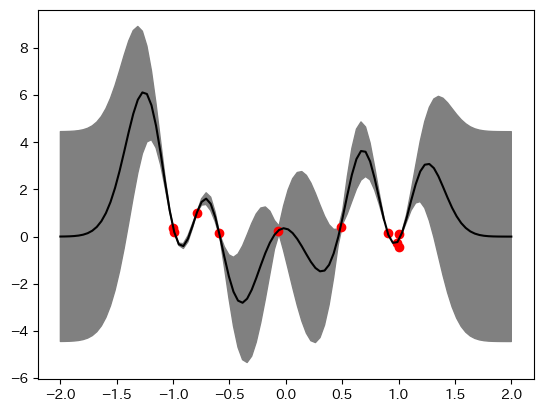

In [ ]:
# 1層目
model.layers[0].save_fig("./outputs/layer_fused0.png")
model.layers[1].save_fig("./outputs/layer_fused1.png")

=== カーネル行列分析 ===

--- Layer 0 ---
z(誘導点)の範囲: [-1.0000, 1.0000]
h(関数値)の範囲: [-0.9857, 2.0776]
計算開始
計算完了
カーネル行列ランク: 3
条件数: 1.17e+17
最小固有値: -2.13e+01
パラメータ値 - s_ij: -2.1901, l_ij: 5.4097, jitter: 0.0047


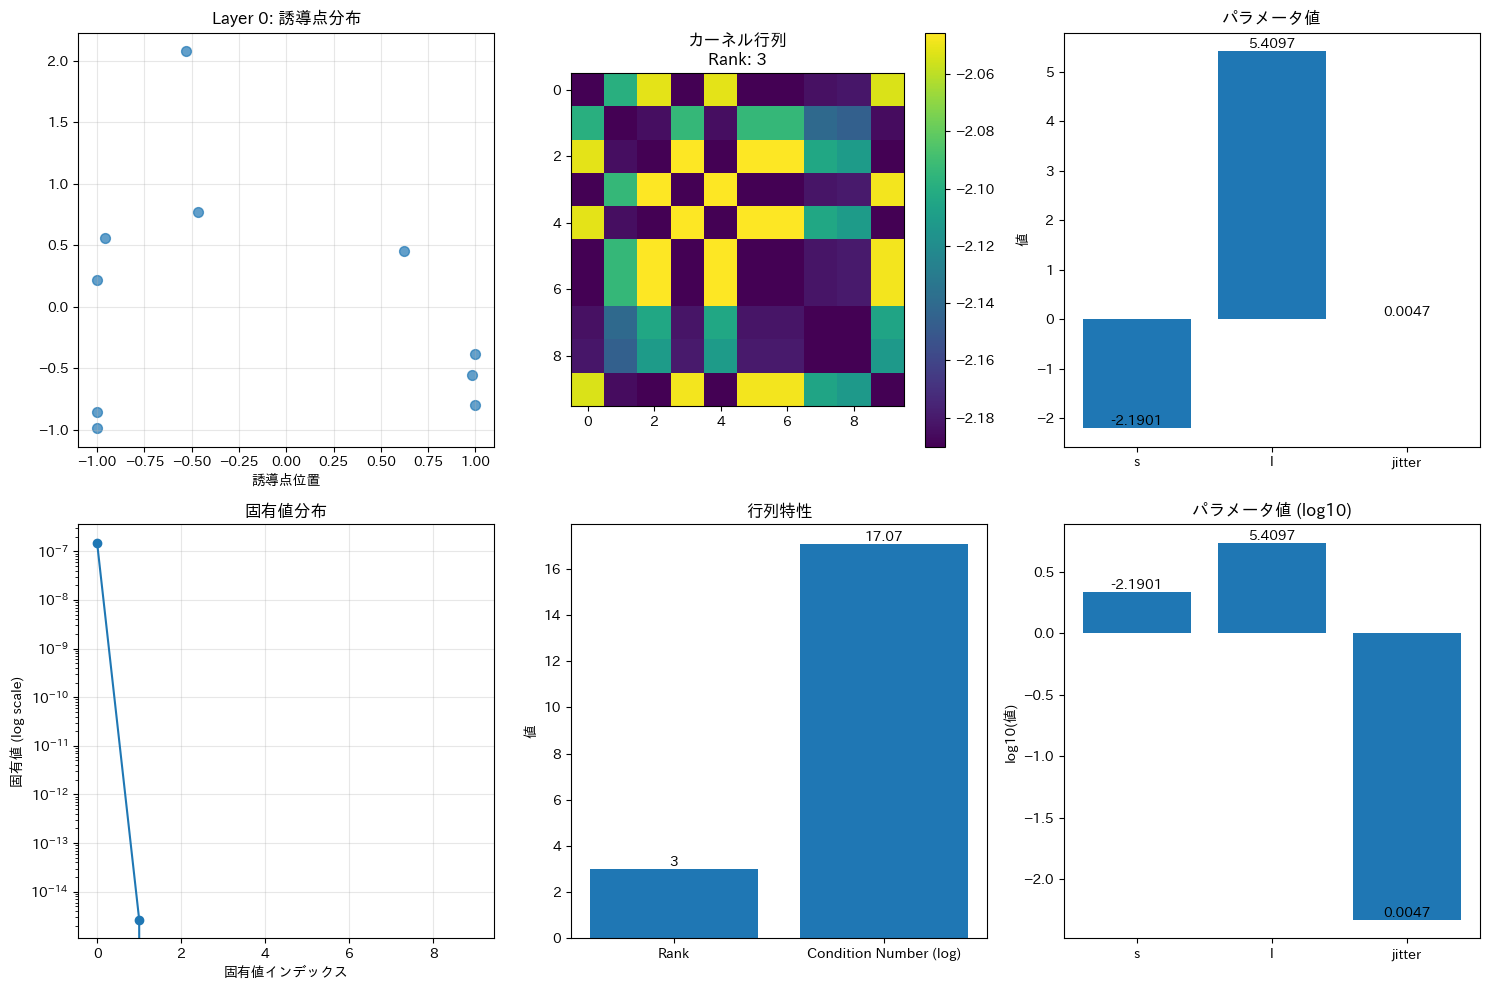

誘導点間距離 - 最小: 0.0000, 最大: 2.0000, 平均: 1.1124


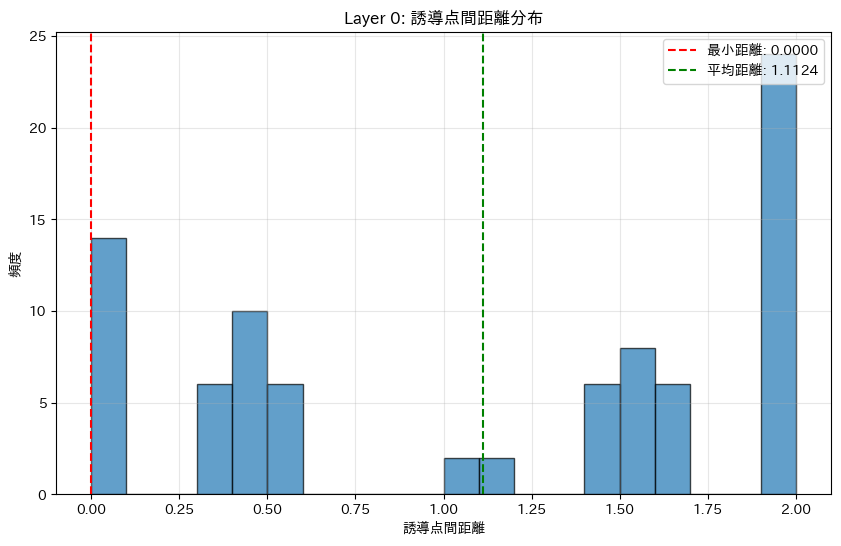


--- Layer 1 ---
z(誘導点)の範囲: [-1.0000, 1.0000]
h(関数値)の範囲: [-0.4432, 1.0181]
計算開始
計算完了
カーネル行列ランク: 4
条件数: 2.76e+09
最小固有値: -6.56e-08
パラメータ値 - s_ij: 0.7532, l_ij: -3.8382, jitter: 0.0025


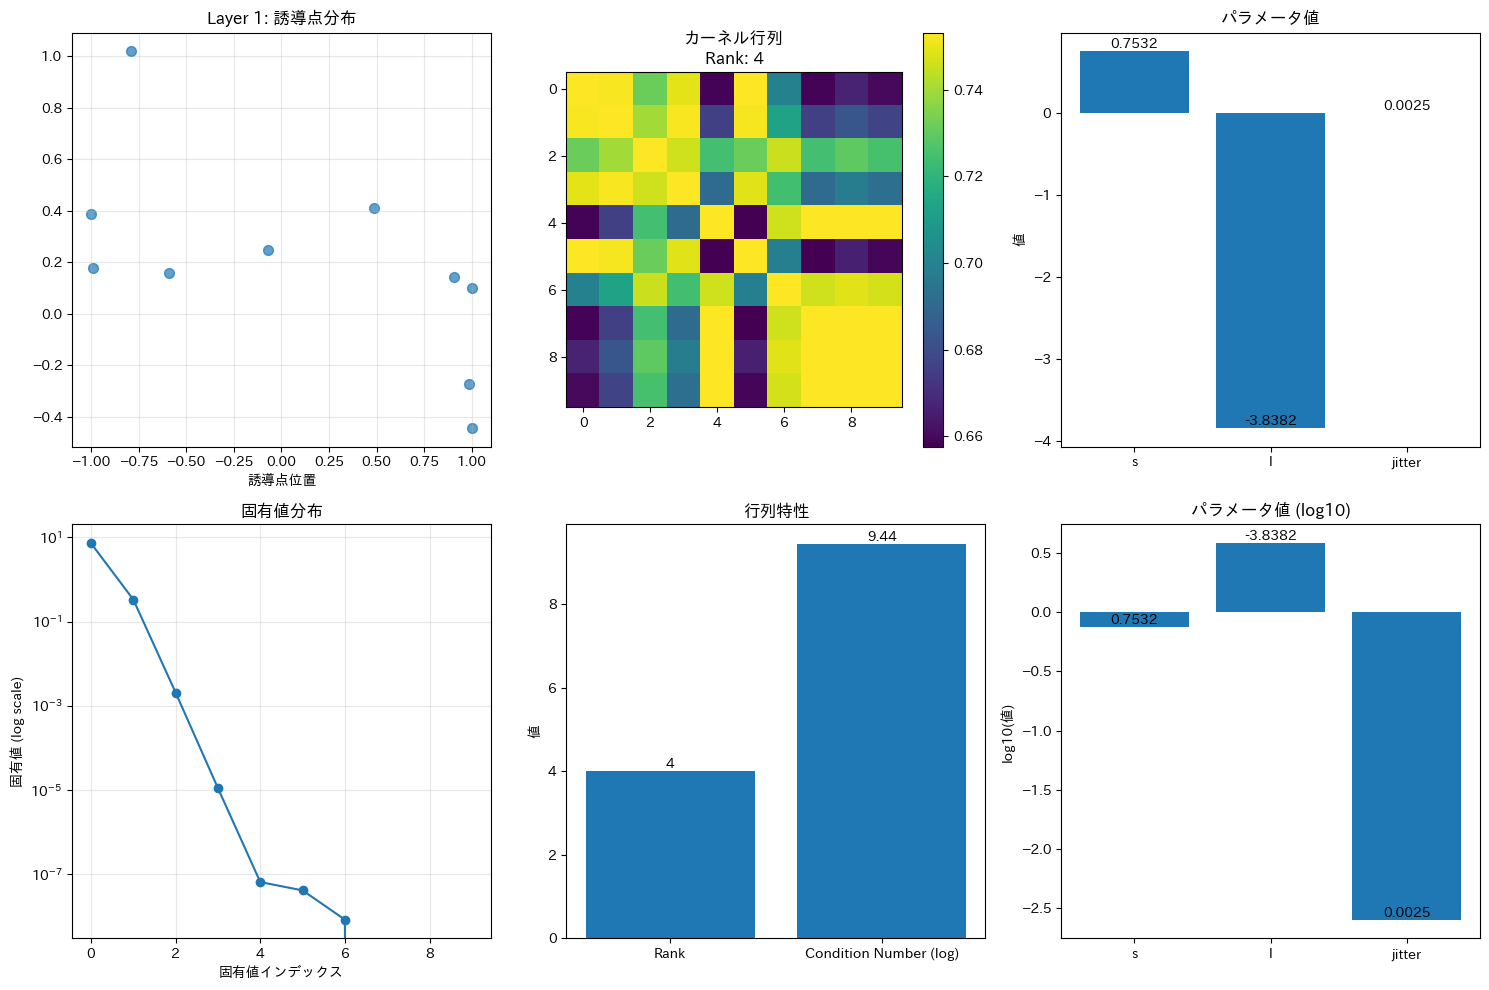

誘導点間距離 - 最小: 0.0002, 最大: 2.0000, 平均: 1.0184


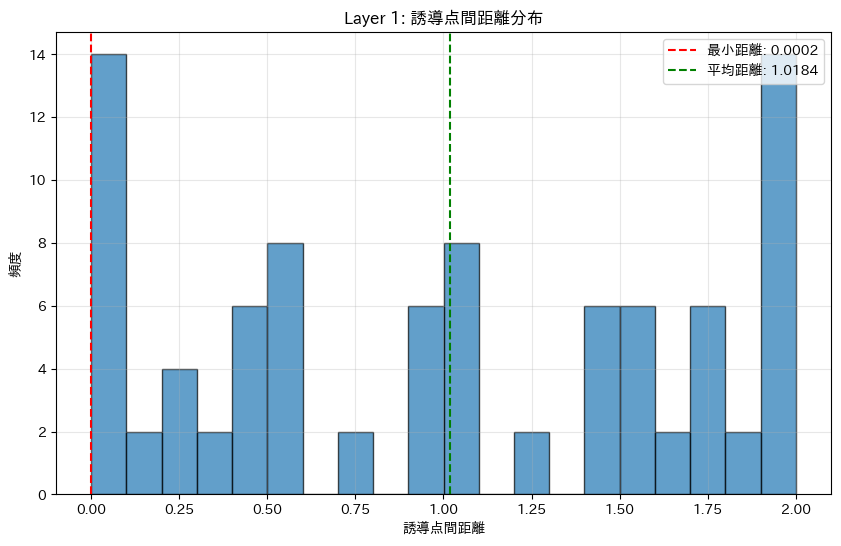

In [ ]:
# カーネル行列のランク可視化・分析
import matplotlib.pyplot as plt
import numpy as np
import torch


def analyze_kernel_matrices(model):
    """
    GP-KANの各層のカーネル行列ランクと条件数を分析・可視化する
    """
    print("=== カーネル行列分析 ===")

    # 各層の分析
    for layer_idx, layer in enumerate(model.layers):
        print(f"\n--- Layer {layer_idx} ---")

        # 誘導点を取得
        z_range = layer.get_z().detach()  # 入力値
        h_range = layer.h.detach()  # 出力値
        jitter = layer.get_jitter().detach()  # Shape: [1, 1]
        print(
            f"z(誘導点)の範囲: [{z_range.min().item():.4f}, {z_range.max().item():.4f}]"
        )
        print(
            f"h(関数値)の範囲: [{h_range.min().item():.4f}, {h_range.max().item():.4f}]"
        )

        # カーネル行列を計算
        with torch.no_grad():
            # カーネル行列を計算
            lengthscale = layer.l.detach()  # Shape: [1, 1]
            variance = layer.s.detach()  # Shape: [1, 1]

            # Set i=j=1 for processing (assuming we want the first GP component)
            i, j = 0, 0  # Using 0-based indexing for tensor access

            # Get parameters for this specific GP
            z_ij = z_range[i, j, :]  # Shape: [X]
            l_ij = lengthscale[i, j]  # Scalar
            s_ij = variance[i, j]  # Scalar

            # Reshape inducing points for distance computation
            z_ij = z_ij.unsqueeze(1)  # Shape: [X, 1]

            # Compute kernel matrix for this GP
            pairwise_sq_dists = torch.cdist(z_ij, z_ij, p=2) ** 2
            # 誘導点間のカーネル行列
            K = s_ij * torch.exp(-pairwise_sq_dists / (2 * l_ij**2))

            print("計算開始")
            # ランク計算
            rank_clean = torch.linalg.matrix_rank(K)

            # 条件数計算
            cond_clean = torch.linalg.cond(K)

            # 固有値
            eigenvals_clean = torch.linalg.eigvals(K).real

            print("計算完了")

            print(f"カーネル行列ランク: {rank_clean.item()}")
            print(f"条件数: {cond_clean.item():.2e}")
            print(f"最小固有値: {eigenvals_clean.min().item():.2e}")
            print(
                f"パラメータ値 - s_ij: {s_ij.item():.4f}, l_ij: {l_ij.item():.4f}, jitter: {jitter.item():.4f}"
            )

        # 可視化
        fig, axes = plt.subplots(2, 3, figsize=(15, 10))

        # 誘導点の分布
        axes[0, 0].scatter(
            z_range.numpy(),
            h_range.numpy(),
            alpha=0.7,
            s=50,
        )
        axes[0, 0].set_title(f"Layer {layer_idx}: 誘導点分布")
        axes[0, 0].set_xlabel("誘導点位置")
        axes[0, 0].grid(True, alpha=0.3)

        # カーネル行列のヒートマップ
        im1 = axes[0, 1].imshow(K.numpy(), cmap="viridis")
        axes[0, 1].set_title(f"カーネル行列\nRank: {rank_clean.item()}")
        plt.colorbar(im1, ax=axes[0, 1])

        # パラメータ値のプロット
        params = ["s", "l", "jitter"]
        values = [s_ij.item(), l_ij.item(), jitter.item()]
        axes[0, 2].bar(params, values)
        axes[0, 2].set_title("パラメータ値")
        axes[0, 2].set_ylabel("値")
        for i, v in enumerate(values):
            axes[0, 2].text(i, v, f"{v:.4f}", ha="center", va="bottom")

        # 固有値分布
        eigenvals_sorted = torch.sort(eigenvals_clean, descending=True)[0]
        axes[1, 0].semilogy(eigenvals_sorted.numpy(), "o-")
        axes[1, 0].set_title("固有値分布")
        axes[1, 0].set_xlabel("固有値インデックス")
        axes[1, 0].set_ylabel("固有値 (log scale)")
        axes[1, 0].grid(True, alpha=0.3)

        # 条件数とランクの可視化
        metrics = ["Rank", "Condition Number (log)"]
        metric_values = [rank_clean.item(), np.log10(cond_clean.item())]
        axes[1, 1].bar(metrics, metric_values)
        axes[1, 1].set_title("行列特性")
        axes[1, 1].set_ylabel("値")
        for i, v in enumerate(metric_values):
            if i == 0:
                axes[1, 1].text(i, v, f"{int(v)}", ha="center", va="bottom")
            else:
                axes[1, 1].text(i, v, f"{v:.2f}", ha="center", va="bottom")

        # パラメータ値の詳細プロット（対数スケール）
        axes[1, 2].bar(params, np.log10(np.abs(values)))
        axes[1, 2].set_title("パラメータ値 (log10)")
        axes[1, 2].set_ylabel("log10(値)")
        for i, v in enumerate(values):
            axes[1, 2].text(i, np.log10(abs(v)), f"{v:.4f}", ha="center", va="bottom")

        plt.tight_layout()
        plt.show()

        # 誘導点間の距離分析
        distances = torch.cdist(z_ij.unsqueeze(0), z_ij.unsqueeze(0)).squeeze(
            0
        )  # Shape: [X, X]
        min_dist = distances[distances > 0].min()
        max_dist = distances[distances > 0].max()
        mean_dist = distances[distances > 0].mean()

        print(
            f"誘導点間距離 - 最小: {min_dist.item():.4f}, 最大: {max_dist.item():.4f}, 平均: {mean_dist.item():.4f}"
        )

        # 距離分布のヒストグラム
        plt.figure(figsize=(10, 6))
        dist_flat = distances[distances > 0].numpy()
        plt.hist(dist_flat, bins=20, alpha=0.7, edgecolor="black")
        plt.axvline(
            min_dist.item(),
            color="red",
            linestyle="--",
            label=f"最小距離: {min_dist.item():.4f}",
        )
        plt.axvline(
            mean_dist.item(),
            color="green",
            linestyle="--",
            label=f"平均距離: {mean_dist.item():.4f}",
        )
        plt.xlabel("誘導点間距離")
        plt.ylabel("頻度")
        plt.title(f"Layer {layer_idx}: 誘導点間距離分布")
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.show()


# 実行
analyze_kernel_matrices(model)

### 考察
第一層の誘導点が端点に集中してしまった

→GLOBAL_JITTER: s,lが発散してしまったため学習がうまくいかなかったと考えられる。一方カーネル行列(ノイズ項付き)は正則性が維持され、パラメータ更新処理自体は動作した。